# Use Napari to plot tissue images for Figure 1 (DAPI + WGA, segmentation masks, spots)

We will use napari with manually annotated ROIs to generate plots for zoom-ins of DAPI+WGA stacks, segmentation masks as well as spots.

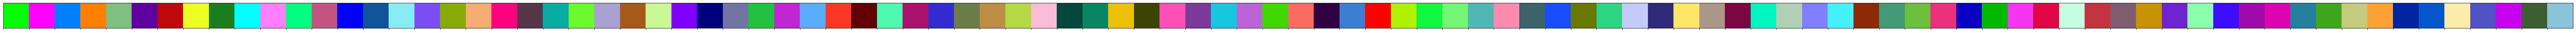

In [126]:
# just installing napari, geopandas and tifffile should be enough to import everything
import pandas as pd
import napari
import skimage.io
import geopandas as gp
from shapely.geometry import Polygon
import distinctipy
import seaborn as sns
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import sys
from skimage.segmentation import find_boundaries
sys.path.append("../")
from spatialMI_functions import plot_layers_napari, crop_black_margins, add_scalebar, crop_coords

# Get a list of distinct colors
colors = distinctipy.get_colors(100)
sns.palplot(colors)

## Generate full sized image of DAPI + WGA with ROI region highlighted

In [ ]:
sample = "sample_2d_r1_s1"
colors = ["#fc6b09","#0090ad","#cadb2b","#cb2027","#029e88", "#e18d9a"]

# napari_screenshot = '../../output/molkart/molkart_figure1_images/'+sample+'.napari_screen.full_image.png'
# roi = pd.read_csv("../../data/molkart_tissue_regions_rois/"+sample+".figure_1_roi.csv")

## image
img_dir = "../../../results/nf-core_molkart/stack/"
img_stack=  skimage.io.imread(img_dir+sample+"_stack.ome.tif")
xmax, ymax = img_stack[[0]].shape[2], img_stack[[1]].shape[1]

## segmentation mask
img_dir = "../../../results/nf-core_molkart/filtered_masks/"
mask = skimage.io.imread(img_dir+sample+"_cellpose_filtered.tif")

## Spots
spots = pd.read_csv('../../../results/nf-core_molkart/mindagap/'+sample+"_"+sample+'.spots_markedDups.txt', delimiter='\t', header=None)
# Please name the columns of spots X,Y,Z and gene
spots.columns = ['x', 'y', 'z', 'gene_target']
# Filter out gene with the name Duplicated
spots = spots[spots.gene != "Duplicated"]

## ROI for zoom in
roi = pd.read_csv("../../annotations/molkart/Figure1_regions/"+sample+".zoom_in.csv")

## Output
outdir = "../../output/molkart/figure1_images/"

In [89]:
## Generate 
viewer = napari.view_image(img_stack, channel_axis = 0,
                           name=["nuclei", "membrane"],
                           colormap=["cyan", "magenta"],
                           contrast_limits=[[1000, 65535], [1000, 65535]],)

# viewer.add_labels(mask)

roi_array = [roi.iloc[:, -2:].to_numpy()]
viewer.add_shapes(roi_array, shape_type=['polygon'],
                  edge_color='white', edge_width=40, face_color="transparent", opacity=1)
full_screenshot = outdir+sample+".dapi_wga.full_image.wborder.png"
viewer.screenshot(path=full_screenshot, scale=3)

crop_screenshot = outdir+sample+".dapi_wga.full_image.clean.png"
crop_black_margins(full_screenshot, crop_screenshot)

# crop_scalebar = outdir+sample+".dapi_wga.full_image.clean.png"
# add_scalebar(crop_screenshot, ymax,
#              scalebar_length_um=10,
#              corner="bottom right", image_with_scalebar_path=crop_scalebar, font_size=200)

/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (19296, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (19296, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (19296, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274:

## Plot full spots image

In [127]:
points_data = spots
gdf = gp.GeoDataFrame(
    points_data, geometry=gp.points_from_xy(
        points_data.x, points_data.y)
        )
# Loading the polygon in x and y since that is how you gave the data, but napari saves in y, x order unless you rearranged dim order
polygon = Polygon(roi.iloc[:, :-3:-1].to_numpy())
poly_gpd = gp.GeoDataFrame(index=[0], geometry=[polygon])

# Basically fastest way to get all points within a polygon.
subset_points = gp.sjoin(gdf, poly_gpd, predicate='within')
points_view = gdf
xmax, ymax = points_view["x"].max(), points_view["y"].max()

points_view = points_view.sort_values(by='gene_target')
points_view['cell_id'] = points_view.index

# We use the gene target code, which is an integer as for the color cycle it is not accepted to have a string. However, with text we can still see the gene target
## create a dictionary with gene_target as key and integers from 0 to X as values
gene_target_dict = {k: v for v, k in enumerate(points_view['gene_target'].unique())}
points_props = {'cell_id': points_view['cell_id'].to_numpy(),
                # Fill the gene_target column with values for each gene stored in the dictionary
                'gene_target': points_view['gene_target'].map(gene_target_dict).to_numpy()
}

viewer = napari.Viewer()
viewer.add_points(points_view[['y', 'x']].to_numpy(),
                  properties=points_props,
                  face_color='gene_target',
                  face_color_cycle=colors,
                  size=20,
                  edge_width_is_relative=False)

roi_array = [roi.iloc[:, -2:].to_numpy()]
viewer.add_shapes(roi_array, shape_type=['polygon'],
                  edge_color='white', edge_width=40, face_color="transparent", opacity=1)

full_screenshot = outdir+sample+".spots.full.wborder.png"
viewer.screenshot(path=full_screenshot, scale=3)

crop_screenshot = outdir+sample+".spots.full.clean.png"
crop_black_margins(full_screenshot, crop_screenshot)

## Plot zoom in of DAPI + WGA

In [30]:
bbox = roi.iloc[:, -2:].to_numpy()
# Using coordinates from bbox to crop the image
crop = img_stack[:, int(bbox[0, 0]):int(bbox[2, 0]), int(bbox[0, 1]): int(bbox[2, 1])]
crop
# xmax, ymax = image_view[[0]].shape[2], image_view[[0]].shape[1]

array([[[ 9947, 10486,  8572, ..., 17240, 16395, 16725],
        [10132, 10068,  9392, ..., 15671, 18423, 15695],
        [10317,  9650, 11399, ..., 16444, 16182, 16508],
        ...,
        [  265,   897,   265, ..., 31025, 36251, 39022],
        [  265,   265,   265, ..., 28970, 35305, 38403],
        [  265,   265,   265, ..., 27606, 32405, 36572]],

       [[12116, 14300, 13536, ..., 14469, 13162, 16066],
        [11083, 11915, 13367, ..., 13584, 13540, 15390],
        [10427, 10870, 11179, ..., 12104, 13331, 14509],
        ...,
        [ 2284,  2284,  2284, ..., 32884, 31448, 29361],
        [ 2284,  1652,  2284, ..., 33825, 31166, 30933],
        [ 2284,  2284,  2284, ..., 30527, 29047, 31890]]], dtype=uint16)

In [35]:
## Generate 
## Crop img_stack to roi, be aware that img_stack is a 2 channel image, so both channels need to be cropped to the same size
viewer = napari.view_image(crop, channel_axis = 0,
                           name=["nuclei", "membrane"],
                           colormap=["cyan", "magenta"],
                           contrast_limits=[[1000, 65535], [1000, 65535]],)

roi_array = [roi.iloc[:, -2:].to_numpy()]
viewer.add_shapes(roi_array, shape_type=['polygon'],
                  edge_color='white', edge_width=40, face_color="transparent", opacity=1)
full_screenshot = outdir+sample+".dapi_wga.zoom.wborder.png"
viewer.screenshot(path=full_screenshot, scale=3)

crop_screenshot = outdir+sample+".dapi_wga.zoom.cropped.png"
crop_black_margins(full_screenshot, crop_screenshot)

crop_scalebar = outdir+sample+".dapi_wga.zoom.clean.png"
add_scalebar(crop_screenshot, ymax,
             scalebar_length_um=10,
             corner="bottom right", image_with_scalebar_path=crop_scalebar, font_size=150)

'../../output/molkart/figure1_images/sample_2d_r1_s1.dapi_wga.zoom.clean.png'

## Plot Mask on top of zoom in

In [90]:
mask_crop = mask[int(bbox[0, 0]):int(bbox[2, 0]), int(bbox[0, 1]): int(bbox[2, 1])]
viewer = napari.view_image(crop, channel_axis = 0,
                           name=["nuclei", "membrane"],
                           colormap=["cyan", "magenta"],
                           contrast_limits=[[1000, 65535], [1000, 65535]],)
boundaries = find_boundaries(mask_crop, mode='thick')
viewer.add_labels(boundaries, visible=True, opacity = 1,color={0:'transparent', 1:(1,1,1)})

full_screenshot = outdir+sample+".dapi_wga.zoom.wborder.png"
viewer.screenshot(path=full_screenshot, scale=3)

crop_screenshot = outdir+sample+".dapi_wga.zoom.clean.png"
crop_black_margins(full_screenshot, crop_screenshot)

# crop_scalebar = outdir+sample+".dapi_wga.zoom.clean.png"
# add_scalebar(crop_screenshot, ymax,
#              scalebar_length_um=20,
#              corner="bottom right", image_with_scalebar_path=crop_scalebar, font_size=200)

## Plot only mask

In [129]:
viewer = napari.Viewer()
viewer.add_labels(mask_crop)

full_screenshot = outdir+sample+".mask.zoom.wborder.png"
viewer.screenshot(path=full_screenshot, scale=3)

crop_screenshot = outdir+sample+".mask.zoom.clean.png"
crop_black_margins(full_screenshot, crop_screenshot)

Context leak detected, msgtracer returned -1


## Plot spots in zoom-in

In [104]:
points_data = spots
gdf = gp.GeoDataFrame(
    points_data, geometry=gp.points_from_xy(
        points_data.x, points_data.y)
        )
# Loading the polygon in x and y since that is how you gave the data, but napari saves in y, x order unless you rearranged dim order
polygon = Polygon(roi.iloc[:, :-3:-1].to_numpy())
poly_gpd = gp.GeoDataFrame(index=[0], geometry=[polygon])

# Basically fastest way to get all points within a polygon.
subset_points = gp.sjoin(gdf, poly_gpd, predicate='within')
points_view = crop_coords(roi, subset_points)
xmax, ymax = points_view["x"].max(), points_view["y"].max()

points_view = points_view.sort_values(by='gene_target')
points_view['cell_id'] = points_view.index

# We use the gene target code, which is an integer as for the color cycle it is not accepted to have a string. However, with text we can still see the gene target
## create a dictionary with gene_target as key and integers from 0 to X as values
gene_target_dict = {k: v for v, k in enumerate(points_view['gene_target'].unique())}
points_props = {'cell_id': points_view['cell_id'].to_numpy(),
                # Fill the gene_target column with values for each gene stored in the dictionary
                'gene_target': points_view['gene_target'].map(gene_target_dict).to_numpy()
}

viewer = napari.Viewer()
boundaries = find_boundaries(mask_crop, mode='thick')
viewer.add_labels(boundaries, visible=True, opacity = 1,color={0:'transparent', 1:(1,1,1)})
viewer.add_points(points_view[['y', 'x']].to_numpy(),
                  properties=points_props,
                  face_color='gene_target',
                  face_color_cycle=colors,
                  size=3,
                  edge_width_is_relative=False)

full_screenshot = outdir+sample+".spots.zoom.wborder.png"
viewer.screenshot(path=full_screenshot, scale=3)

crop_screenshot = outdir+sample+".spots.zoom.clean.png"
crop_black_margins(full_screenshot, crop_screenshot)

In [81]:
points_props

{'cell_id': array([128041, 128171, 128170, ..., 165060, 164913, 164491]),
 'gene_target': array(['Acta2', 'Acta2', 'Acta2', ..., 'Vim', 'Vim', 'Vim'], dtype=object)}